<a href="https://colab.research.google.com/github/fredmakombe/master-thesis/blob/master/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import tensorflow as tf
from sklearn import datasets
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import linear_sum_assignment

In [0]:
#rng(1) #For reproducibility
r = np.sqrt(np.random.rand(100,1)) #Radius
t = 2*np.pi*np.random.rand(100,1) # Angle
data1 = [r*np.cos(t), r*np.sin(t)] # Points

r2 = np.sqrt(3*np.random.rand(100,1)+1) #Radius
t2 = 2*np.pi*np.random.rand(100,1)   # Angle
data2 = [r2*np.cos(t2), r2*np.sin(t2)] # points


data3 = np.vstack((data1[0], data2[0]))
data4 = np.vstack((data1[1], data2[1]))
X = np.hstack((data3, data4))
y = np.ones(200,)
y[0:100] = 0

In [0]:
# Generate dataset
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)
y = y*1

X, y = datasets.make_blobs(n_samples=200, centers=3, n_features=2, random_state=0)
X, y = datasets.make_circles(n_samples=200, noise=0.19, factor=0.3, random_state=0) ; y[X[:, 0] > 0.1] += 2; y[y==3] = 0

# np.random.shuffle(X)
# Normalize
X -= X.mean(axis=0)
X /= X.std(axis=0)

# Keep a copy for reference down the road
X_orig = X.copy()
y_orig = y.copy()

# Convert labels to categorical one-hot encoding
nclasses = np.unique(y).size
one_hot_encoded = np.eye(nclasses)[y]

In [0]:
color_palette = np.array(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'])

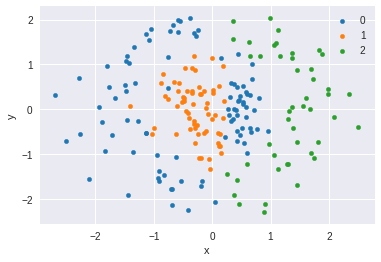

In [129]:
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = dict(zip(range(nclasses), color_palette[:nclasses]))
fig, ax = plt.subplots() 
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

In [0]:
n_samples = X.shape[0]
xs = tf.placeholder(tf.float64)
ys = tf.placeholder(tf.float64)

# layer 1
W_1 = tf.Variable(np.random.randn(2,12))
b_1 = tf.Variable(np.random.randn(12))
Z_1 = tf.add(tf.matmul(xs, W_1), b_1)
layer_1 = tf.nn.relu(Z_1)

# layer 2
W_2 = tf.Variable(np.random.randn(12,8))
b_2 = tf.Variable(np.random.randn(8))
Z_2 = tf.add(tf.matmul(layer_1, W_2), b_2)
layer_2 = tf.nn.relu(Z_2)

# Output layer
W_0 = tf.Variable(np.random.randn(8,nclasses))
b_0 = tf.Variable(np.random.randn(nclasses))
pred = tf.add(tf.matmul(layer_2, W_0), b_0)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=ys, logits=pred)
Loss = tf.reduce_mean(cross_entropy)
train_op = tf.train.AdamOptimizer(0.01).minimize(Loss)

correct_prediction = tf.equal(tf.argmax(ys, 1), tf.argmax(pred, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
grads = tf.gradients(Loss, xs)

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
def pearson_corr(x, y):
  class_corr = {}
  nclasses = np.unique(y)
  for yi in nclasses:
    corr_idxs = np.corrcoef(x[y == yi], rowvar=False)[np.triu_indices(x.shape[-1])]
    class_corr[yi] = corr_idxs[np.logical_not(np.isclose(corr_idxs, 1.))]
  return class_corr

def relabel(y, new_lbls, old_lbls=None):
  if old_lbls is None:
    old_lbls = np.arange(len(new_lbls))
  new_y = np.empty_like(y)
  for ol, nl in zip(old_lbls, new_lbls):
    new_y[y == ol] = nl
  return new_y

In [149]:
correlation_idxs = [pearson_corr(X_orig, y_orig)]
correlation_idxs

[{0: array([0.11256923]), 1: array([0.00630905]), 2: array([-0.22310882])}]

# Plot Dataset and Model Status

53.997794164952374 0.14378291355829348
(19600,)
2.3891547375939086 1.0283215150251913e-07
(19600,)
16.12740808649119 1.25141400050083
(19600,)


Text(0.5,1,'Loss surface: Class 2-Green')

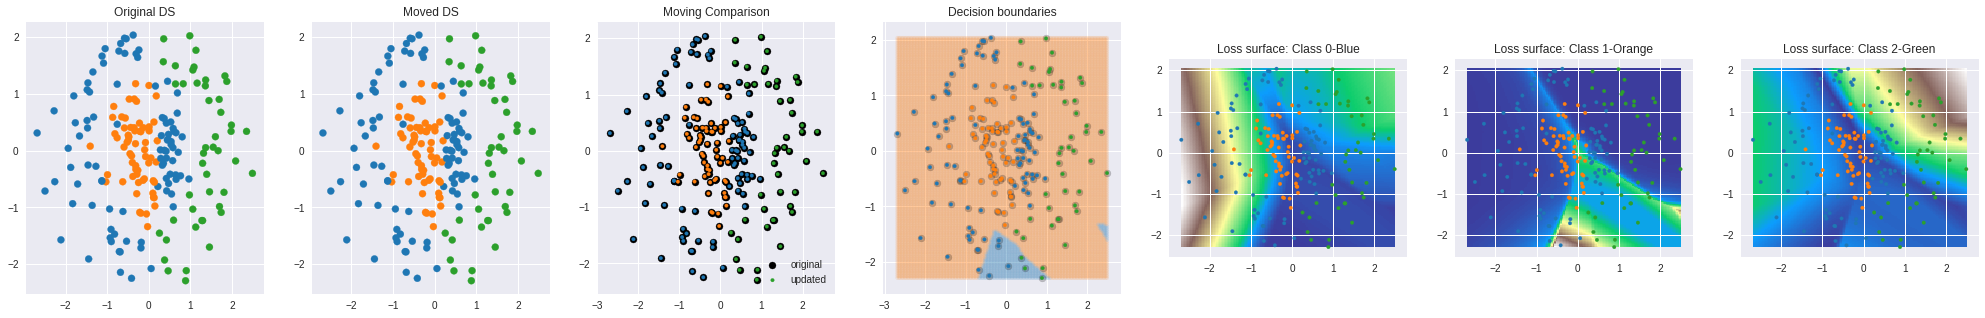

In [134]:
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(5 * 7, 5))

plt.sca(axes[0])
plt.title('Original DS')
plt.scatter(X_orig[:, 0], X_orig[:, 1], c=color_palette[y_orig.flat])

plt.sca(axes[1])
plt.scatter(X[:, 0], X[:, 1], c=color_palette[y_orig.flat])
plt.title('Moved DS')

plt.sca(axes[2])
plt.scatter(X_orig[:, 0], X_orig[:, 1], color='k', label='original')
plt.scatter(X[:, 0], X[:, 1], marker='.', color=color_palette[y_orig.flat], label='updated')
#rain_gradients[0][0]
#_ = [plt.plot([pt0[0], tg[0]+pt0[0]], [pt0[1], tg[1]+pt0[1]], 'k-') for tg, pt0 in zip(np.array(train_gradients)[0].reshape(-1, 2), X_orig)]
#_ = [plt.plot([pt0[0], tg[0]+pt0[0]], [pt0[1], tg[1]+pt0[1]], 'k-') for tg, pt0 in zip(np.array(train_gradients)[1].reshape(-1, 2), X_orig)]
#_ = [plt.plot([pt0[0], tg[0]+pt0[0]], [pt0[1], tg[1]+pt0[1]], 'k-') for tg, pt0 in zip(np.array(train_gradients)[2].reshape(-1, 2), X_orig)]
plt.legend()
plt.title('Moving Comparison')


plt.sca(axes[3])
space_resolution = 140
x0, x1 = np.percentile(X, [0, 100])
nfeats = X.shape[-1]
#space_in = np.random.uniform(x0, x1, size=2000*nfeats).reshape(2000, nfeats)
left_lim, right_lim, bottom_lim, upper_lim = X[:, 0].min(), X[:, 0].max(), X[:, 1].min(), X[:, 1].max()
space_in = np.array(np.meshgrid(np.linspace(left_lim, right_lim, space_resolution), np.linspace(bottom_lim, upper_lim, space_resolution))).reshape(2, -1).T
preds = sess.run(pred, feed_dict={xs: space_in})
y_pred = np.argmax(preds, axis=-1)
plt.scatter(space_in[:, 0], space_in[:, 1], c=color_palette[y_pred.flat], marker='.', alpha=0.1)
plt.scatter(X_orig[:, 0], X_orig[:, 1], color='k', label='original', alpha=0.2)
plt.scatter(X[:, 0], X[:, 1], marker='.', color=color_palette[y_orig.flat], label='updated')
_ = plt.title('Decision boundaries')


loss_cmap = 'terrain'
vmin, vmax = None, None #0, 51.44

# ---

plt.sca(axes[4])
losses = sess.run(cross_entropy, feed_dict={xs: space_in, ys:np.eye(nclasses)[np.zeros_like(y_pred)]})
print(losses.max(), losses.min())
num_color_steps = 255  # < 256
q_colors = np.round(np.linspace(1, 255, num_color_steps)).astype('int')
q_loss_bins = np.histogram(losses, bins=num_color_steps)[1]
print(losses.shape)
plt.imshow(np.flipud(losses.reshape(space_resolution, space_resolution)), cmap=loss_cmap, extent=(left_lim, right_lim, bottom_lim, upper_lim), alpha=0.95, vmin=vmin, vmax=vmax)
#for c_step in range(num_color_steps-1):
#  pt_idxs = (losses < q_loss_bins[c_step + 1]) * (losses >= q_loss_bins[c_step])
#  plt.scatter(space_in[pt_idxs, 0], space_in[pt_idxs, 1], c=plt.cm.terrain(q_colors[c_step]), marker='.', alpha=0.8)

plt.scatter(X[:, 0], X[:, 1], marker='.', color=color_palette[y_orig.flat], label='updated')  
plt.title('Loss surface: Class 0-Blue')
#plt.ylim(0, 2)
#plt.xlim(-0.5, 2)

# ---

plt.sca(axes[5])
losses = sess.run(cross_entropy, feed_dict={xs: space_in, ys:np.eye(nclasses)[np.zeros_like(y_pred)+1]})
print(losses.max(), losses.min())
num_color_steps = 255  # < 256
q_colors = np.round(np.linspace(1, 255, num_color_steps)).astype('int')
q_loss_bins = np.histogram(losses, bins=num_color_steps)[1]
print(losses.shape)
plt.imshow(np.flipud(losses.reshape(space_resolution, space_resolution)), cmap=loss_cmap, extent=(left_lim, right_lim, bottom_lim, upper_lim), alpha=0.95, vmin=vmin, vmax=vmax)
#for c_step in range(num_color_steps-1):
#  pt_idxs = (losses < q_loss_bins[c_step + 1]) * (losses >= q_loss_bins[c_step])
#  plt.scatter(space_in[pt_idxs, 0], space_in[pt_idxs, 1], c=plt.cm.terrain(q_colors[c_step]), marker='.', alpha=0.8)

plt.scatter(X[:, 0], X[:, 1], marker='.', color=color_palette[y_orig.flat], label='updated')
plt.title('Loss surface: Class 1-Orange')
#plt.ylim(0, 2)
#plt.xlim(-0.5, 2)

# ---

plt.sca(axes[6])
losses = sess.run(cross_entropy, feed_dict={xs: space_in, ys:np.eye(nclasses)[np.zeros_like(y_pred)+2]})
print(losses.max(), losses.min())
num_color_steps = 255  # < 256
q_colors = np.round(np.linspace(1, 255, num_color_steps)).astype('int')
q_loss_bins = np.histogram(losses, bins=num_color_steps)[1]
print(losses.shape)
plt.imshow(np.flipud(losses.reshape(space_resolution, space_resolution)), cmap=loss_cmap, extent=(left_lim, right_lim, bottom_lim, upper_lim), alpha=0.95, vmin=vmin, vmax=vmax)
#for c_step in range(num_color_steps-1):
#  pt_idxs = (losses < q_loss_bins[c_step + 1]) * (losses >= q_loss_bins[c_step])
#  plt.scatter(space_in[pt_idxs, 0], space_in[pt_idxs, 1], c=plt.cm.terrain(q_colors[c_step]), marker='.', alpha=0.8)

plt.scatter(X[:, 0], X[:, 1], marker='.', color=color_palette[y_orig.flat], label='updated')
plt.title('Loss surface: Class 2-Green')
#plt.ylim(0, 2)
#plt.xlim(-0.5, 2)

## Solve transportation problem (to assign colors to clusters)

In [135]:
median_class_loss = []
prevalent_classes = []
all_preds = sess.run(pred, feed_dict={xs: X})
for cls in range(nclasses):
  cls_preds = all_preds[(y_orig == cls).flat]
  cls_preds = np.exp(cls_preds)
  cls_preds /= np.sum(cls_preds, axis=-1)[:, np.newaxis]
  losses = np.median(-np.log(cls_preds), axis=0)
  median_class_loss.append(losses)
  prevalent_classes.append(np.argmin(losses))
  print('cls={} lbl={}: {}'.format(cls, prevalent_classes[-1], losses.min()))
  print(losses)

cost_matrix = np.array(median_class_loss).reshape(nclasses, nclasses)
row_idx, col_idx = linear_sum_assignment(cost_matrix)
row_idx_inv, col_idx_inv = linear_sum_assignment(cost_matrix*-1)
print('New label assignment (org, best, worst):')
for y_org in row_idx:
  print('{} ---> {} -x-> {}'.format(row_idx[y_org], col_idx[y_org], col_idx_inv[y_org]))

cls=0 lbl=1: 0.034728700211631464
[9.15988466 0.0347287  3.53142476]
cls=1 lbl=1: 0.1483919760596554
[5.50613673 0.14839198 2.20012483]
cls=2 lbl=1: 0.004357870284516485
[6.25774263e+00 4.35787028e-03 6.10060199e+00]
New label assignment (org, best, worst):
0 ---> 1 -x-> 0
1 ---> 2 -x-> 1
2 ---> 0 -x-> 2


### RE-LABEL?

In [0]:
y_orig = relabel(y_orig, col_idx, old_lbls=row_idx)

## Track data correlation as SGD runs on the data

Correlation per class and per feature over time


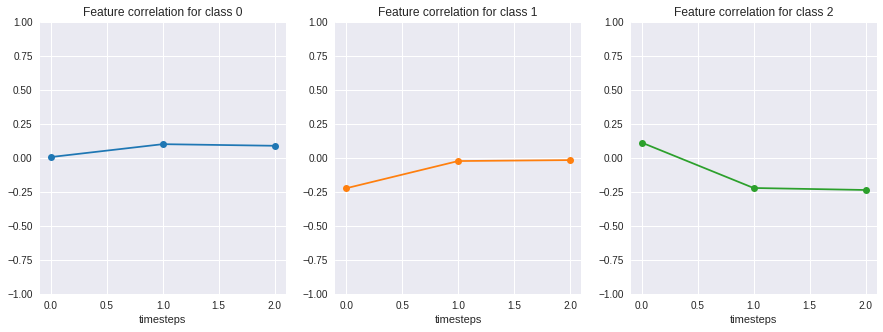

In [148]:
print('Correlation per class and per feature over time')
n_classes = np.unique(y)
fig, axes = plt.subplots(nrows=1, ncols=len(n_classes), figsize=(5*len(n_classes), 5))
for n, yi in enumerate(n_classes):
  axes[n].set_title('Feature correlation for class {}'.format(yi))
  
  corr_yi = [i[yi] for i in correlation_idxs]
  axes[n].plot(range(len(corr_yi)), corr_yi, color=color_palette[yi], marker='o', ls='-')
  axes[n].set_xlabel('timesteps')
  axes[n].set_ylim((-1, 1))
  # axes[n].plot([-0.4, len(corr_yi)-0.4], [corr_yi.mean(), corr_yi.mean()], color=color_palette[yi], ls='--', alpha=0.5)
  
  #corr_yi = correlation_idxs[-1][yi]
  #axes[n].bar(np.arange(len(corr_yi))+0.4, corr_yi, 0.4, color=color_palette[yi], label='last')
  #axes[n].plot([-0.4, len(corr_yi)-0.4], [corr_yi.mean(), corr_yi.mean()], color=color_palette[yi], ls='-')
  # axes[n].legend()


# Train the model parameters: theta

---

Alternate between this loop and the next one

[-0.01386338  0.00563574]


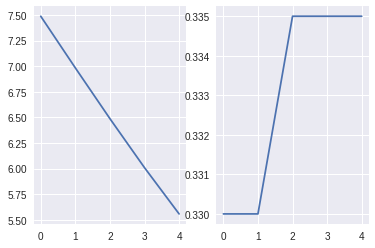

In [138]:
train_loss = []
training_acc = []
train_gradients = []
training_epoch = 5

for epoch in range(training_epoch):
  _, loss, gradients, acc = sess.run([train_op, Loss, grads, accuracy],
                                     feed_dict={xs: X, ys: one_hot_encoded})
  train_loss.append(loss)
  training_acc.append(acc)
  train_gradients.append(gradients)
  
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].plot(range(training_epoch), train_loss)
axes[1].plot(range(training_epoch), training_acc)
axes[0].grid(True)
axes[1].grid(True)
print(np.array(train_gradients).reshape(-1, 2).mean(axis=0))

# Adjust inputs using gradient descent (aka "*train the input*"): X

---

Alternate between this loop and the previous one

[-0.00740968 -0.00038237]


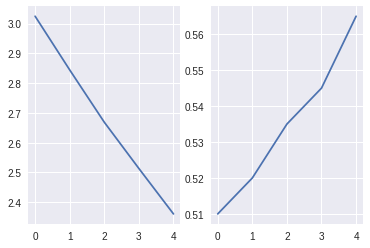

In [147]:
train_loss = []
training_acc = []
train_gradients = []
lr = 0.95

for epoch in range(training_epoch):
    loss, gradients, acc = sess.run([Loss, grads, accuracy],
                                    feed_dict={xs: X, ys: one_hot_encoded})
    train_loss.append(loss)
    training_acc.append(acc)
    train_gradients.append(gradients)
    X -= lr*gradients[0]
    
correlation_idxs.append(pearson_corr(X, y_orig))
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].plot(range(training_epoch), train_loss)
axes[1].plot(range(training_epoch), training_acc)
axes[0].grid(True)
axes[1].grid(True)
print(np.array(train_gradients).reshape(-1, 2).mean(axis=0))

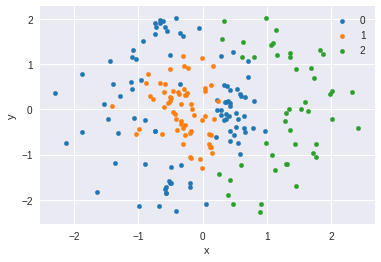

In [140]:
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = dict(zip(range(nclasses), color_palette[:nclasses]))
fig, ax = plt.subplots() 
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

## Random pre-training of the model

[-0.0137187  -0.00167625]


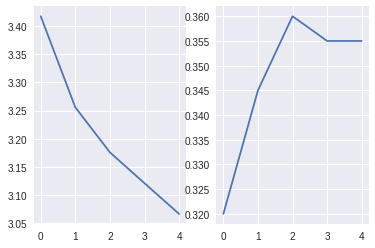

In [141]:
train_loss = []
training_acc = []
train_gradients = []

rnd_ys = np.arange(len(one_hot_encoded))
np.random.shuffle(rnd_ys)

for epoch in range(training_epoch):
  _, loss, gradients, acc = sess.run([train_op, Loss, grads, accuracy],
                                     feed_dict={xs: X, ys: one_hot_encoded[rnd_ys]})
  train_loss.append(loss)
  training_acc.append(acc)
  train_gradients.append(gradients)
  
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].plot(range(training_epoch), train_loss)
axes[1].plot(range(training_epoch), training_acc)
axes[0].grid(True)
axes[1].grid(True)
print(np.array(train_gradients).reshape(-1, 2).mean(axis=0))

In [0]:
ncs = np.array([[0.45490196, 0.77254902, 0.31764706],
       [0.75294118, 0.43921569, 0.30588235],
       [0.38823529, 0.30196078, 0.81960784],
       [0.30196078, 0.58431373, 0.84313725],
       [0.30588235, 0.82352941, 0.74117647],
       [0.3372549 , 0.80392157, 0.40784314],
       [0.54509804, 0.55294118, 0.29019608],
       [0.55686275, 0.29019608, 0.62352941],
       [0.28627451, 0.38431373, 0.73333333],
       [0.2745098 , 0.67058824, 0.70980392],
       [0.28235294, 0.68235294, 0.47843137],
       [0.55686275, 0.32941176, 0.24705882],
       [0.32156863, 0.23529412, 0.56078431],
       [0.22352941, 0.40392157, 0.57254902],
       [0.21568627, 0.54117647, 0.47843137],
       [0.21960784, 0.51372549, 0.29019608],
       [0.3254902 , 0.34509804, 0.18039216],
       [0.32156863, 0.16078431, 0.36078431],
       [0.15294118, 0.18039216, 0.41176471],
       [0.12941176, 0.3254902 , 0.37254902],
       [0.12156863, 0.33333333, 0.22745098],
       [0.1254902 , 0.27843137, 0.09019608],
       [0.21176471, 0.11764706, 0.06666667],
       [0.33333333, 0.62352941, 0.25882353],
       [0.98039216, 0.90196078, 0.95686275],
       [0.87058824, 0.86666667, 0.98039216],
       [0.82745098, 0.90980392, 0.96078431],
       [0.79607843, 0.94901961, 0.90980392],
       [0.76470588, 0.92941176, 0.77254902],
       [0.82745098, 0.81568627, 0.71764706],
       [0.79215686, 0.68235294, 0.85098039],
       [0.65098039, 0.70588235, 0.89019608],
       [0.36078431, 0.8627451 , 0.58431373],
       [0.61568627, 0.86666667, 0.88235294],
       [0.6       , 0.87058824, 0.71372549],
       [0.62745098, 0.81568627, 0.55686275],
       [0.79215686, 0.60392157, 0.52941176],
       [0.5254902 , 0.49803922, 0.84313725],
       [0.47843137, 0.68627451, 0.85098039],
       [0.45882353, 0.84705882, 0.74509804],
       [0.4627451 , 0.84705882, 0.48627451],
       [0.65882353, 0.61568627, 0.40392157],
       [0.64705882, 0.38823529, 0.72156863],
       [0.37254902, 0.47843137, 0.85098039],
       [0.35294118, 0.81176471, 0.85882353]])

from matplotlib.colors import LinearSegmentedColormap
spmap = LinearSegmentedColormap.from_list('spmap', ncs)

In [0]:
losses = sess.run(cross_entropy, feed_dict={xs: space_in, ys:np.eye(nclasses)[np.zeros_like(y_pred)+2]})

In [0]:
 params = {}
params['hyper'] = {'epochs': 10, 'learning_rate': 0.01}

In [145]:
params['hyper']['learning_rate']

0.01